In [2]:
import sys
sys.path.insert(0, '/home/taylorm/espr/src')
import hsa
import numpy as np 
import xarray as xr
import xarray.ufuncs as xu
import bottleneck
import datetime
import os
import paths as ps
import utils as ut
import plot
from line_profiler import LineProfiler

In [71]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import matplotlib.colors as mc
import paths as ps 
import numpy as np
import xarray as xr 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from datetime import datetime

class Map:
    def __init__(self, hsa, input_map, variable, dpi=72):
        self.variable = variable
        self.dpi = dpi
        self.hsa = self._convert_to_da(hsa)
        self.input_map = self._convert_to_da(input_map)
        self.font = fm.FontProperties(fname=ps.fpath)
        self.font_bold = fm.FontProperties(fname=ps.fpath_bold)
        self.levels = np.linspace(-3,3,13)
        self.variable_range = self._set_variable_range()
        self._generate_map()

    def _convert_to_da(self, array):
        if type(array) == xr.Dataset:
            array = array[[n for n in array][0]]
            return array
        else:
            return array
            
    def _set_variable_range(self):
        if self.variable == 'slp':
            return np.arange(900,1100,4)
        elif self.variable == 'pwat':
            return np.arange(0,100,2)
        elif self.variable == 'wnd':
            return np.arange(0,150,2)
        elif 'tmp' in self.variable:
            self.input_map = self.input_map - 273.15
            return np.arange(-50,50,4)

    def _generate_map(self):
        fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': ccrs.Miller()})
        ax.add_feature(cf.NaturalEarthFeature(
            'cultural', 'admin_1_states_provinces_lines', '50m',
            edgecolor='gray', facecolor='none'))
        ax.add_feature(cf.NaturalEarthFeature(
            'cultural', 'admin_1_states_provinces_lines', '50m',
            edgecolor='gray', facecolor='none'))        
        ax.add_feature(cf.LAKES, facecolor='gray')
        ax.add_feature(cf.BORDERS, edgecolor='gray')
        ax.add_feature(cf.RIVERS, edgecolor='gray')
        ax.add_feature(cf.OCEAN, facecolor='gray')
        ax.set_extent([-180,-50,20,65],crs=ccrs.PlateCarree())
        ax.coastlines(resolution='50m')
        self.hsa = self.hsa.rename('Sigma')
        n=35
        x = 0.5
        cmap = plt.cm.RdBu_r
        lower = cmap(np.linspace(0, x, n))
        white = np.ones((80-2*n,4))
        upper = cmap(np.linspace(1-x, 1, n))
        colors = np.vstack((lower, white, upper))
        tmap = mc.LinearSegmentedColormap.from_list('map_white', colors)
        try:
            c = self.hsa.where(np.abs(self.hsa) > 0.5).plot.pcolormesh(
                ax=ax,
                transform=ccrs.PlateCarree(),
                levels=self.levels,
                add_colorbar=False,
                cmap=tmap,
                alpha=0.9
            )
        except ValueError:
            pass
        try:
            if self.variable == 'slp':
                cl = (self.input_map/100).plot.contour(
                    ax=ax,
                    colors = 'k',
                    transform=ccrs.PlateCarree(),
                    levels=self.variable_range,
                    add_colorbar=False,
                    linewidths=0.5)
            else:
                cl = self.input_map.plot.contour(
                ax=ax,
                colors = 'k',
                transform=ccrs.PlateCarree(),
                levels=self.variable_range,
                add_colorbar=False,
                linewidths=0.5
            )
            ax.clabel(cl, fmt='%3.0f')
        except:
            if self.variable == 'slp':
                (self.input_map/100).plot.contour(
                    ax=ax,
                    colors = 'k',
                    transform=ccrs.PlateCarree(),
                    levels=self.variable_range,
                    add_colorbar=False,
                    linewidths=0.5)
            else:
                self.input_map.plot.contour(
                ax=ax,
                colors = 'k',
                transform=ccrs.PlateCarree(),
                levels=self.variable_range,
                add_colorbar=False,
                linewidths=0.5
            )
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.001, axes_class=plt.Axes, aspect=30)
        fig.add_axes(ax_cb)
        cb = plt.colorbar(c, cax=ax_cb)
        cb.set_label(label='Sigma',fontsize=16)
        date = self.hsa.valid_time.dt.strftime("%Y/%m/%d %Hz").values
        step = self.hsa.step.values.astype("timedelta64[h]")/np.timedelta64(1, "h")
        ax.set_title(f'HISTORICAL SPREAD ANOMALY',

        fontsize=16,
        loc='left')
        ax.set_title(f'FHOUR: {step:3.0f}',

        fontsize=14,
        loc='center')
        ax.set_title(f'VALID: {date}',

        fontsize=14,
        loc='right')
        plt.show()  


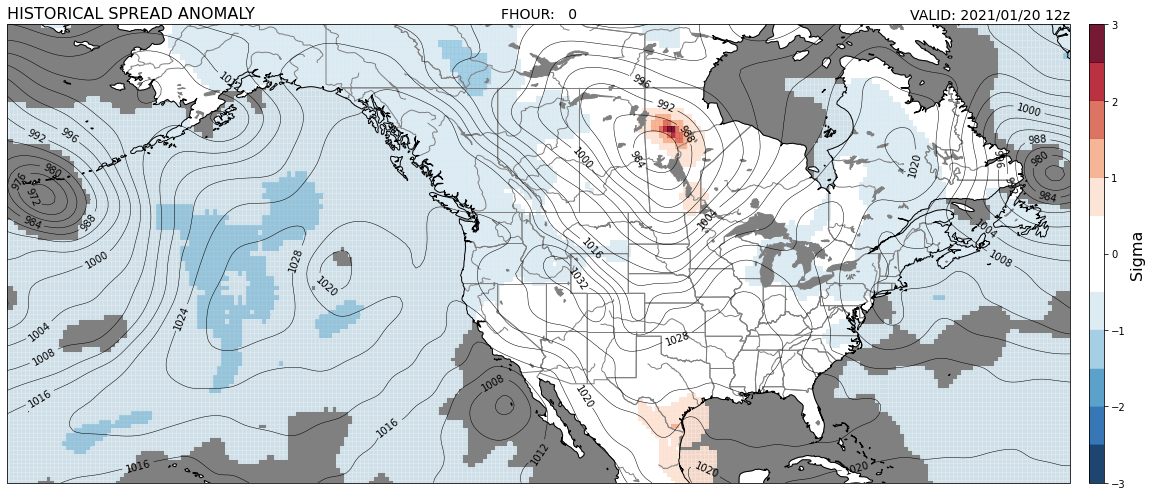

In [72]:
hsa_final = xr.open_dataset('../output/20210120_12/slp_hsa.nc')
gefs_mean = xr.open_dataset('../output/20210120_12/slp_mean.nc')
Map(hsa_final['Pressure'][0], gefs_mean['Pressure'][0], 'slp')

In [19]:
hsa_final

<xarray.Dataset>
Dimensions:     (fhour: 29, lat: 121, lon: 261)
Coordinates:
  * lon         (lon) float64 180.0 180.5 181.0 181.5 ... 309.0 309.5 310.0
  * fhour       (fhour) timedelta64[ns] 0 days 00:00:00 ... 7 days 00:00:00
    step        (fhour) timedelta64[ns] ...
    meanSea     int64 ...
  * lat         (lat) float64 80.0 79.5 79.0 78.5 78.0 ... 21.5 21.0 20.5 20.0
    valid_time  (fhour) datetime64[ns] ...
Data variables:
    Pressure    (fhour, lat, lon) float32 -1.7523679 -1.7718157 ... 0.44189152